In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8
device="cuda"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import torchaudio
import random
from itertools import combinations
from IPython.display import HTML, Audio
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop, Resize
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
dataset = datasets.load_dataset("danjacobellis/musdb_segments")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.F = 512
config.latent_dim = 16;
config.input_channels = 2
config.lightweight_encode = True
config.lightweight_decode = False
config.post_filter = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.progressive_sizes = [config.F*int(s) for s in 2**(np.linspace(10,12,1000))]; print(config.progressive_sizes[0],config.progressive_sizes[-1])
config.batch_size = 16
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.epochs = 1000
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False

524288 2097152


In [4]:
model = AutoCodecND(
    dim=1,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
    post_filter=config.post_filter
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

103.72328 M parameters


In [5]:
mixing_weights = []

# Original mixture
mixing_weights.append(torch.ones(4))

# Amplify two channels, attenuate two
for indices in combinations(range(4), 2):
    weights = torch.full((4,), 0.5)
    weights[list(indices)] = 1.5
    mixing_weights.append(weights)

# Combinations of 3 channels (set to 1.0), one channel set to 0.0
for indices in combinations(range(4), 3):
    weights = torch.zeros(4)
    weights[list(indices)] = 1.0
    mixing_weights.append(weights)

# Combinations of 2 channels (set to 1.0), others set to 0.0
for indices in combinations(range(4), 2):
    weights = torch.zeros(4)
    weights[list(indices)] = 1.0
    mixing_weights.append(weights)

# Combinations of 1 channel
for index in range(4):
    weights = torch.zeros(4)
    weights[index] = 1.0
    mixing_weights.append(weights)

def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def collate_fn(batch,epoch):
    L = get_epoch_size(epoch)
    C = config.input_channels
    crop = RandomCrop((4, L))
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi = torch.zeros((C,4,2**21), dtype=torch.int16)
        for i_instr, instr in enumerate(['vocal', 'bass', 'drums', 'other']):
            audio, fs = torchaudio.load(sample[f'audio_{instr}']['bytes'], normalize=False)
            xi[:,i_instr,:] = audio
        xi = crop(xi).to(torch.float)
        w = random.choice(mixing_weights).view(1, -1, 1)
        xi = (w*xi).sum(dim=1)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        x[i_sample,:,:] = xi
    return x

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        if i_epoch/config.epochs <= config.freeze_encoder_after :
            z = model.encode(x)
            z_noisy = model.quantize(z) 
            x_hat = model.decode(z_noisy)
        else:
            with torch.no_grad():
                z = model.encode(x)
                z_quant = model.quantize.compand(z).round()
            x_hat = model.decode(z_quant)

        if config.post_filter:
            x_hat = model.post_filter(x_hat)

        # Reconstruction and rate loss
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate = model.quantize.compand(z).std().log2()
        rate_losses.append(rate.item())

        if i_epoch/config.epochs <= config.freeze_encoder_after :
            total_loss = mse_loss + config.λ * rate
        else:
            total_loss = mse_loss

        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"LR: {learning_rates[-1]:.2g}")

        # Backpropagation and optimizer step
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])

        global_step += 1

    torch.save({
        'config': config,
        'state_dict': model.state_dict()
    }, 'checkpoint.pth')

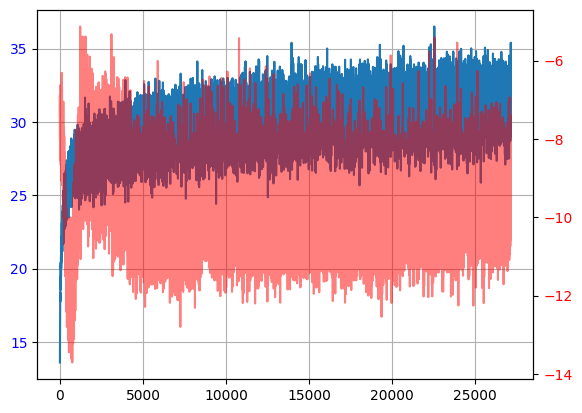

In [7]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [8]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../hf/dance/LF_stereo_f512c16_v1.0.pth')

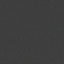

143.01363884342607 compression ratio
64.0× dimension reduction
34.03336050033569 dB PSNR


In [14]:
import einops

L = 2**19
C = config.input_channels
center_crop = CenterCrop((1, L))
def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi = torch.zeros((C, 1, 2**21), dtype=torch.int16)
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'], normalize=False)
        xi[:, 0, :] = audio_mix
        xi = center_crop(xi).to(torch.float)
        xi = xi.squeeze(1)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        x[i_sample, :, :] = xi
    return x

batch = dataset['validation'].select([0])
x = valid_collate_fn(batch).to(device)
model.eval()
with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round().cpu()
    latent_reshaped = einops.rearrange(latent, 'b c (h w) -> b c h w', h=32)
    latent_img = latent_to_pil(latent_reshaped, n_bits=8, C=4)
    display(latent_img[0])
    buff = io.BytesIO()
    latent_img[0].save(buff, format='TIFF', compression='tiff_adobe_deflate')
    tiff_bytes = buff.getbuffer()
    print(f"{x.numel()/len(tiff_bytes)} compression ratio")
    print(f"{x.numel()/z.numel()}× dimension reduction")
    latent_decoded = pil_to_latent([PIL.Image.open(buff)], N=16, n_bits=8, C=4)
    latent_decoded = einops.rearrange(latent_decoded, 'b c h w -> b c (h w)')
    x_hat = model.decode(latent_decoded.to(device))
    if config.post_filter:
        x_hat = model.post_filter(x_hat)
    x_hat = x_hat.clamp(-1,1)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

In [ ]:
Audio(x_hat[0].cpu(),rate=44100)

(-4.0, 4.0)

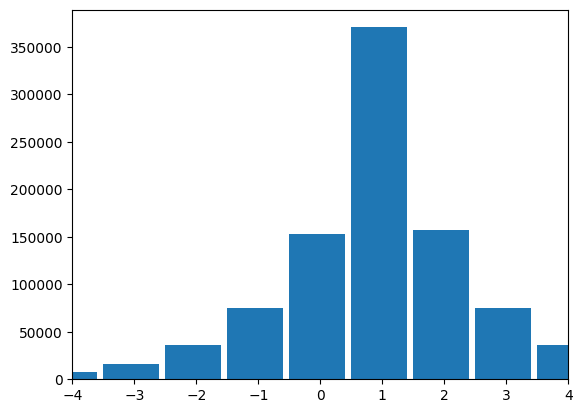

In [9]:
plt.hist(z_quant.flatten().cpu().numpy(),range=(-127.5,127.5),bins=255,width=0.9);
plt.xlim([-4,4])